In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Data
import pandas as pd
from os import sep as sep
import os
import matplotlib.cm as cm
import scipy.stats as stats

In [2]:
root_path = 'Y:\Lior&Einav\Experiments'
exp_details = pd.read_excel(root_path + sep + 'Experiments_details.xlsx', engine='openpyxl')
exp_details = exp_details.drop(index=0)  # remove pilot experiment
# exps_to_remove = [20, 23]
# exp_details = exp_details.drop(exp_details[exp_details.Experiment.isin(exps_to_remove)].index)
exp_details

,Experiment,Larvae_present,Colony,P_yellow,C_yellow,P_red,C_red
1,11,yes,A,2,1,1,3
2,12,no,A,2,1,1,3
3,13,no,A,2,1,1,3
4,16,no,B,2,1,1,3
5,17,no,B,2,1,1,3
6,18,yes,A,2,1,1,3
7,19,yes,A,2,1,1,3
9,21,no,B,2,1,1,3
10,22,no,B,2,1,1,6
12,24,no,B,2,1,1,6


In [3]:
def get_exp_path(exp_num, root_path):
    folderlist = os.listdir(root_path)
    exp_folder = [x for x in folderlist if x.startswith('experiment'+str(exp_num))]
    return root_path + sep + exp_folder[0]

In [4]:
def get_PC_ratios_dict(exp_details,row_idx):
    PC_ratios_dict = {}
    for color in ['yellow', 'red']:
        PC_ratios_dict[color] = [exp_details.loc[row_idx,'P_'+color], exp_details.loc[row_idx,'C_'+color]]
    return PC_ratios_dict

In [5]:
def get_exp_data(exp_num, exp_details, root_path):
    exp_path = get_exp_path(exp_num, root_path)
    exp_idx = exp_details.index[exp_details.Experiment==exp_num][0]
    PC_ratios_dict = get_PC_ratios_dict(exp_details,exp_idx)
    fdata = pd.read_csv(exp_path + sep + 'forager_table_with_feeding_sizes_ul_transparency_corrected.csv')
    
    return exp_idx, PC_ratios_dict, fdata, exp_path

In [6]:
def get_exp_convergence(fdata, PC_ratios_dict):
    fdata[['P_mg','C_mg']] = fdata.apply(lambda x: pd.Series
                                         (Data.food_volume_to_PC_amounts(x['feeding_size_ul'],
                                                                         PC_ratios_dict[x['food_source']])),
                                         axis=1)
    
    fdata = fdata.sort_values(by='feeding_start')
    fdata['cumP_mg'] = np.cumsum(fdata['P_mg'])
    fdata['cumC_mg'] = np.cumsum(fdata['C_mg'])
    fdata = fdata.reset_index().sort_values(by='feeding_start')
    fdata['colony_PC_ratio'] = fdata['cumP_mg']/fdata['cumC_mg']
    final_ratio = fdata['colony_PC_ratio'].iloc[-1]
    
    exp_convergence = fdata['colony_PC_ratio']-final_ratio
    
    return exp_convergence

In [7]:
def plot_mean_convergence(exp_indexes, color, ax):
    all_convergences = []
    for exp_num in exp_indexes:
        
        exp_idx, PC_ratios_dict, fdata, exp_path = get_exp_data(exp_num, exp_details, root_path)

        exp_convergence = get_exp_convergence(fdata, PC_ratios_dict)
        exp_convergence.name = 'convergence_'+str(exp_num)

        all_convergences.append(exp_convergence)
        
    convergence_df = pd.concat(all_convergences,axis=1)
    mean_abs = convergence_df.abs().mean(axis=1)
    std_abs = convergence_df.abs().std(axis=1)
    sem_abs = convergence_df.abs().sem(axis=1)
    
    ax.plot(mean_abs,color)
    ax.fill_between(mean_abs.index, mean_abs-sem_abs, mean_abs+sem_abs,color=color,alpha=0.2)

In [8]:
larvae_present = exp_details.Experiment[exp_details.Larvae_present == 'yes'].to_list()

In [9]:
no_larvae = exp_details.Experiment[(exp_details.Colony == 'B') & (exp_details.C_red==3)].to_list()

In [10]:
extra_sugar = exp_details.Experiment[exp_details.C_red==6].to_list()

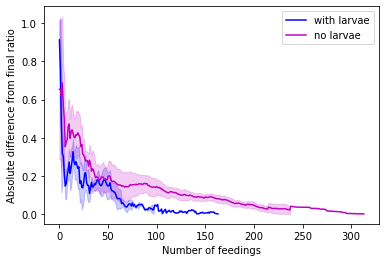

In [11]:
fig,ax = plt.subplots()
plot_mean_convergence(larvae_present, 'b', ax)
plot_mean_convergence(no_larvae,'m', ax)
#plot_mean_convergence(extra_sugar,'g',ax)
plt.xlabel('Number of feedings')
plt.ylabel('Absolute difference from final ratio')
#plt.ylim([0,0.25])
plt.legend(['with larvae','no larvae'])

In [12]:
def get_exp_relative_convergence(fdata, PC_ratios_dict, num_bins=50):
    convergence = get_exp_convergence(fdata, PC_ratios_dict)
    convergence = pd.concat([convergence,pd.Series(convergence.index/max(convergence.index),name='relative feeding')],axis=1)
    convergence['relative feeding bin'] = pd.cut(convergence['relative feeding'],num_bins,labels=False)
    convergence_mean = convergence.groupby('relative feeding bin').apply(np.mean)
    convergence_mean.index.rename('index',inplace=True)
    return convergence_mean

In [13]:
def get_mean_and_sem_relative_convergence(convergences_list_abs):
    all_convergences = pd.concat(convergences_list_abs)
    convergences_mean = all_convergences.groupby('relative feeding bin')['colony_PC_ratio'].apply(np.mean)
    convergences_sem = all_convergences.groupby('relative feeding bin')['colony_PC_ratio'].apply(stats.sem)
    return convergences_mean, convergences_sem

In [14]:
def plot_relative_convergence(exp_nums, ax, color='b',num_bins=50):
    all_convergences_abs = []
    for exp_num in exp_nums:
        exp_idx, PC_ratios_dict, fdata, exp_path = get_exp_data(exp_num, exp_details, root_path)
        relative_convergence = get_exp_relative_convergence(fdata, PC_ratios_dict)
        all_convergences_abs.append(relative_convergence.reset_index().abs())
    convergences_mean, convergences_sem = get_mean_and_sem_relative_convergence(all_convergences_abs)
    
    ax.plot(np.linspace(0,1,num_bins,endpoint=False),convergences_mean,color)
    ax.fill_between(np.linspace(0,1,num_bins,endpoint=False),convergences_mean-convergences_sem,
                convergences_mean+convergences_sem,alpha=0.2, color=color)
    return convergences_mean, convergences_sem

In [15]:
%matplotlib qt
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
convergence_mean_larvae, _ = plot_relative_convergence(larvae_present,ax[0],'b')
ax[0].set_ylim([0,1])
ax[0].set_title('With larvae')
convergence_mean_nolarvae, _ = plot_relative_convergence(no_larvae,ax[1],'m')
ax[1].set_ylim([0,1])
ax[1].set_title('No larvae')
#plot_relative_convergence(extra_sugar,ax,'g')
#plt.legend(['with larvae','no larvae'])
fig.supxlabel('Fraction of feedings')
fig.supylabel('Absolute difference from final ratio')
ax[0].axvline(0.6,ls='--',color='k')
ax[1].axvline(0.74,ls='--',color='k')

In [20]:
fig, ax = plt.subplots(2,3, sharex=False, sharey=True)
# with larvae
counter = 0
for exp_num in larvae_present:
    exp_idx, PC_ratios_dict, fdata, exp_path = get_exp_data(exp_num, exp_details, root_path)
    exp_convergence = get_exp_convergence(fdata, PC_ratios_dict)
    ax[0,counter].axhline(color='k',linewidth=0.8)
    #ax[0,counter].plot(fdata.sort_values(by='feeding_start').feeding_start,exp_convergence,'b')
    ax[0,counter].plot(exp_convergence,color='b')
    #ax[0,counter].set_xlim([0,11700])
    #ax[0,counter].set_ylim([-0.23,1.25])
    counter += 1
    
    
    
# no larvae
counter = 0
for exp_num in no_larvae:
    exp_idx, PC_ratios_dict, fdata, exp_path = get_exp_data(exp_num, exp_details, root_path)
    exp_convergence = get_exp_convergence(fdata, PC_ratios_dict)
    ax[1,counter].axhline(color='k',linewidth=0.8)
    #ax[1,counter].plot(fdata.sort_values(by='feeding_start').feeding_start,exp_convergence,'m')
    ax[1,counter].plot(exp_convergence,color='m')
    #ax[1,counter].set_xlim([0,11700])
    #ax[1,counter].set_ylim([-0.23,1.25])
    counter += 1
    
#fig.supxlabel('Number of feedings')
#fig.supylabel('Difference from final ratio')

In [ ]:
fdata.head()

In [ ]:
def find_convergence_point(signal,xaxis,margin=0.04):
    

In [ ]:
x = convergence_mean_larvae
x<0.04

In [ ]:
74-60

In [ ]:
80-64

In [ ]:
ax[0].axvline(0.6,ls='--',color='k')

In [ ]:
ax[1].axvline(0.74,ls='--',color='k')